# read_SIZRS_data

Load AXCTD data from the SIZRS experiment, convert to an xarray dataset, save as a .nc file
(alternatively, this code could be put in a function to just read the raw data & convert to xarray dataset, without saving)

info here:
http://psc.apl.uw.edu/research/projects/sizrs/

data are stored on google drive [here](https://drive.google.com/drive/folders/0B5_0Q9aVQm9gTzV0eVgyRkZ6cGM?resourcekey=0-SGB_gxxdIvTOKe_i9kYLWA), so there's no way to download them via commandline. Instead, I zipped the entire directory, downloaded it to my local machine, unzipped the files, and then uploaded them to github into the "data" folder. Note that .gitignore includes .txt, which means that the data shouldn't be automatically be pulled. To pull the data files, use "git pull --force"



In [1]:
# imports 
import sys
import os
import numpy as np
import glob
from datetime import datetime, time, date, timedelta
import pandas as pd
import xarray as xr

# plotting stuff
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker


In [11]:
# directories - all of which sit within the repo
sizrsdir = './data/AXCTD/'  # 
savedir = './process/'
figdir = './figures/'

# create these if they don't exist:
for d in [sizrsdir, savedir, figdir]:
    if not(os.path.isdir(d)):
        os.mkdir(d)        

In [13]:
# variables to store
vbls = ['Temp', 'Salinity'] # also 'Sigma'
# rename these variables for consistency with other code. Note that we're saving surface values only.
vbls_save = ['SST', 'SSS']

In [8]:
# we will extract data at the surface.... 
# but first let's take a look at the upper 10 m - regrid the data to "zgrid"
z_extract = 0 # final depth of extraction
zgrid = np.arange(0,5,0.1) # vertical grid for the first-look

./data/AXCTD/SIZRS_2012_AXCTDs/
saving ./process/SIZRS_2012.nc
saving ./process/SIZRS_2012.nc
saving ./process/SIZRS_2012.nc
saving ./process/SIZRS_2012.nc
saving ./process/SIZRS_2012.nc
saving ./process/SIZRS_2012.nc
./data/AXCTD/SIZRS_2013_AXCTDs/
saving ./process/SIZRS_2013.nc
saving ./process/SIZRS_2013.nc
saving ./process/SIZRS_2013.nc
./data/AXCTD/SIZRS_2014_AXCTDs/
saving ./process/SIZRS_2014.nc
saving ./process/SIZRS_2014.nc
saving ./process/SIZRS_2014.nc
saving ./process/SIZRS_2014.nc
saving ./process/SIZRS_2014.nc
./data/AXCTD/SIZRS_2015_AXCTDs/
saving ./process/SIZRS_2015.nc
saving ./process/SIZRS_2015.nc
saving ./process/SIZRS_2015.nc
saving ./process/SIZRS_2015.nc
./data/AXCTD/SIZRS_2016_AXCTDs/
saving ./process/SIZRS_2016.nc
saving ./process/SIZRS_2016.nc
saving ./process/SIZRS_2016.nc
saving ./process/SIZRS_2016.nc
saving ./process/SIZRS_2016.nc
./data/AXCTD/SIZRS_2017_AXCTDs/
saving ./process/SIZRS_2017.nc
saving ./process/SIZRS_2017.nc
saving ./process/SIZRS_2017.nc
sa

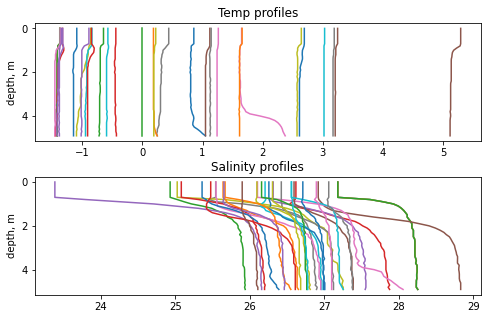

In [85]:
# year(s) and month(s) to process:
# years from 2012 to 2019 and months 6-10 are typically available
years = range(2012,2020)

# set up figure
# fig, axes = plt.figure(figsize=(16,8), subplots=(9,2))

    
# loop through years
for year in years:
    # initialize output array - one per year
    xctd_thisyear = xr.Dataset(coords={'z':zgrid, 't':time})
    # this year's data directory
    thisdir = f'{sizrsdir}SIZRS_{year}_AXCTDs/'
    print(thisdir)
    # months in this year
    monthdirs = sorted(glob.glob(thisdir + '*AXCTDs_*'))
    for monthdir in monthdirs:
        file_list = sorted(glob.glob(monthdir +  '*/AXCTD*.txt'))
        cnt = 0 # count
        for filename in file_list:
            cnt+=1
            # load, skip the header, and close
            # print(filename)
            f = open(filename,'r')    
            header = f.readlines()[0:13] 
            f.close()

            # look for header line with lat/lon/date info
            for r in range(np.size(header)):
                i = header[r].find("North")
                if i>0:
                    # TO DO:  make more generic with regexp or similar
                    hsplit = header[r].split(" ")
                    if hsplit[1] == 'degrees': # some files are formatted like this
                        lat = float(hsplit[0])
                        lon = -1*(float(hsplit[5]))
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))
                    else: # some like this
                        lat = float(hsplit[0]) + float(hsplit[2])/60
                        lon = -1*(float(hsplit[6]) + float(hsplit[8])/60)
                        time = np.datetime64(datetime.strptime(hsplit[-2],'%Y-%m-%d/%H%M'))

            # load data into a pandas dataframe: 
            df = pd.read_csv(filename, sep='\s+', skiprows=15, names=["Depth", "Pres", "Temp", "Cond", "Salinity", "Sigma"])

            # if this is the first file in the month, initialize the xr dataset and add time
            
            if cnt==1:
                xctd_thismonth = xr.Dataset(coords={'z':zgrid, 't':time})
                
            # interpolate each variable to zgrid and store in the xarray dataset:
            # add data to the new xarray dataset this_xctd
            this_xctd = xr.Dataset(coords={'z':zgrid, 't':time, 'x':lon, 'y':lat})
            for vbl in vbls:
                this_xctd[vbl] = xr.DataArray(data=np.interp(zgrid, df['Depth'], df[vbl]), dims=['z'])

    
            # concatenate files
            xctd_thisyear = xr.concat([xctd_thisyear, this_xctd], dim='t')
            xctd_thismonth = xr.concat([xctd_thismonth, this_xctd], dim='t')
            
        # at the end of each year, save to netcdf
        SIZRS = xctd_thisyear.copy() # copy to a new dataset
        SIZRS = SIZRS.sel(z=z_extract) # extract one depth (surface)
        SIZRS = SIZRS.sortby('t')  # make sure times are sorted
        # rename variables
        for vi in range(len(vbls)):
            SIZRS = SIZRS.rename_vars({vbls[vi]:vbls_save[vi]})
    
        filename_out = f'{savedir}SIZRS_{np.datetime_as_string(time, unit="Y")}.nc'
        print('saving ' + filename_out)
        SIZRS.to_netcdf(filename_out)

        
    
# at the end of the last year, plot profiles
fig, axs = plt.subplots(2, 1, figsize=(8,5))
fig.subplots_adjust(hspace=0.3)

for vi in [0,1]:
    axx = axs[vi]
    axx.plot(np.transpose(xctd_thisyear[vbls[vi]].data), xctd_thisyear.z.data)
    axx.invert_yaxis()
    axx.set_title(f'{vbls[vi]} profiles')
    axx.set_ylabel('depth, m')

        
